In [54]:
#Part 1: Data Preparation and Exploration
#Data Loading
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset and parse dates
df = pd.read_csv('exchange_rate.csv', parse_dates=[0])
df.rename(columns={df.columns[0]: 'Date', df.columns[1]: 'USD_AUD'}, inplace=True)

df.set_index('Date', inplace=True)
print(df.head())


                  USD_AUD
Date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


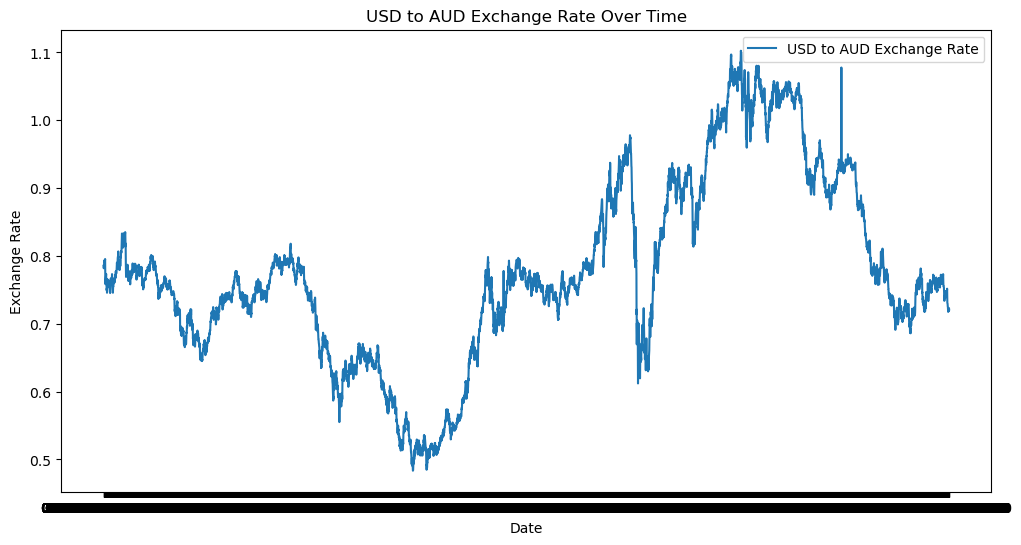

In [55]:
#Initial Exploration
#Plot the USD to AUD exchange rate time series:
plt.figure(figsize=(12,6))
plt.plot(df['USD_AUD'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

USD_AUD    0
dtype: int64


C:\Users\APPY\AppData\Local\Temp\ipykernel_12724\685418245.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['USD_AUD'].fillna(method='ffill', inplace=True)
C:\Users\APPY\AppData\Local\Temp\ipykernel_12724\685418245.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['USD_AUD'].fillna(method='ffill', inplace=True)


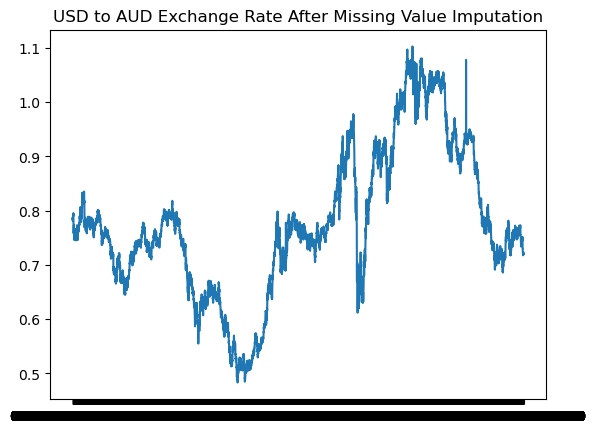

In [56]:
#Data Preprocessing
#Check for missing values and anomalies:
print(df.isnull().sum())

# Impute missing values if any (e.g., forward fill)
df['USD_AUD'].fillna(method='ffill', inplace=True)

# Optionally plot again to verify
plt.plot(df['USD_AUD'])
plt.title('USD to AUD Exchange Rate After Missing Value Imputation')
plt.show()

ADF Statistic: -1.664994180738073
p-value: 0.44923273535983155


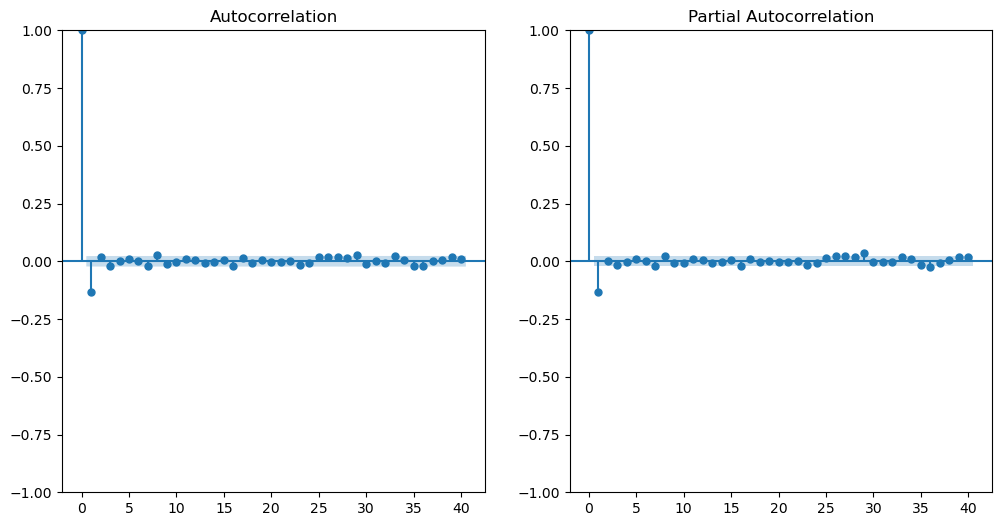

In [57]:
#Part 2: Model Building - ARIMA
#1. Parameter Selection for ARIMA (ACF and PACF)
# Use statsmodels to plot ACF and PACF to help choose p, d, q:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(df['USD_AUD'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Differencing if series is non-stationary
df_diff = df['USD_AUD'].diff().dropna()

plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(df_diff, ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(df_diff, ax=plt.gca(), lags=40)
plt.show()




In [58]:
#Model Fitting
from statsmodels.tsa.arima.model import ARIMA

# Example: ARIMA(p=1,d=1,q=1)
model = ARIMA(df['USD_AUD'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 08 Jun 2025   AIC                         -56102.322
Time:                        12:25:45   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.608      0.0

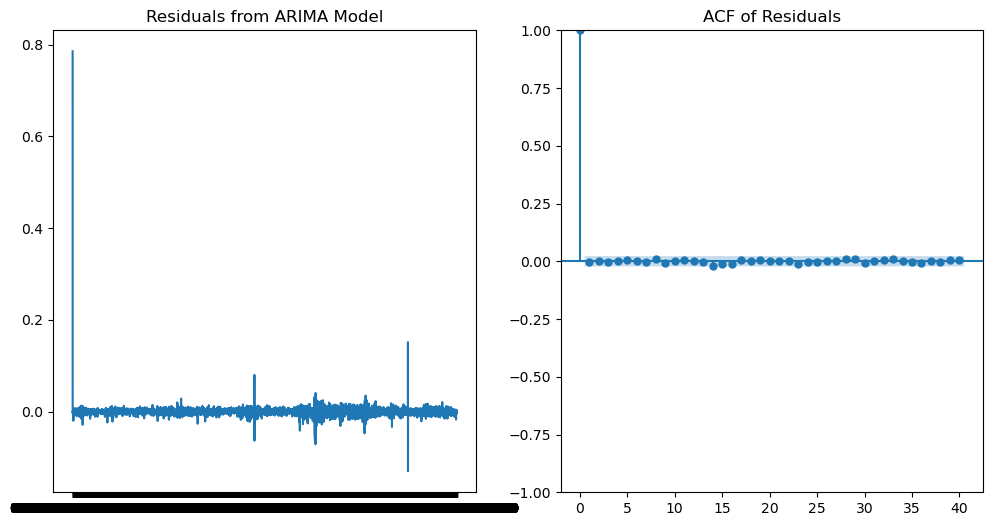

In [59]:
#Diagnostics
#Check residuals for white noise (no pattern):
residuals = model_fit.resid

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')

plt.subplot(122)
plot_acf(residuals.dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.show()


In [60]:
print(df.columns)

Index(['USD_AUD'], dtype='object')


In [61]:
df.index = pd.to_datetime(df.index, dayfirst=True)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


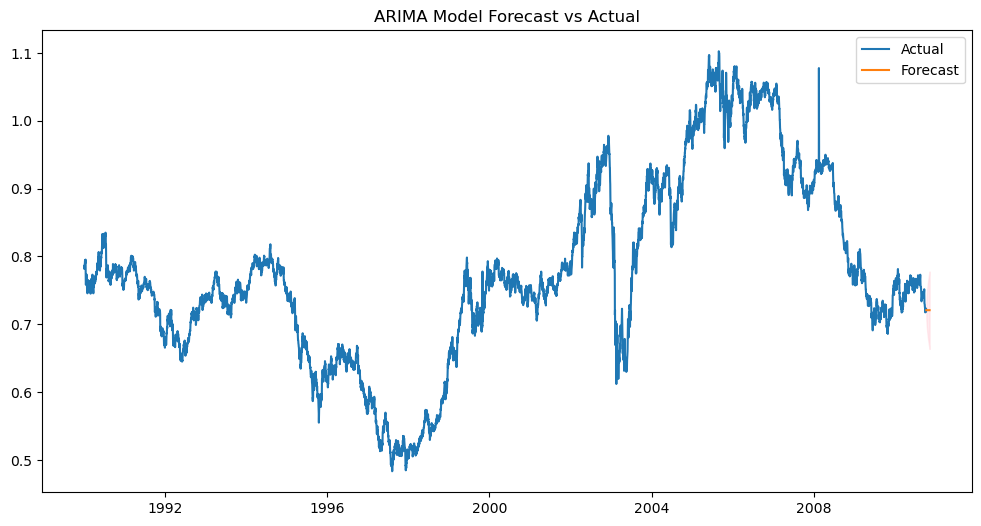

In [62]:
n_forecast = 30
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_forecast)

plt.figure(figsize=(12,6))
plt.plot(df['USD_AUD'], label='Actual')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:,0],
                 forecast.conf_int().iloc[:,1], color='pink', alpha=0.3)
plt.title('ARIMA Model Forecast vs Actual')
plt.legend()
plt.show()


In [63]:
#Part 3: Model Building - Exponential Smoothing
#1. Model Selection
#We can start with Holt-Winters if seasonality is suspected, else Holt's Linear or Simple Exponential Smoothing.
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Try Holt-Winters (additive seasonality)
model_es = ExponentialSmoothing(df['USD_AUD'], trend='add', seasonal=None)  # Use seasonal='add' if seasonality known
fit_es = model_es.fit()
print(fit_es.summary())


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  USD_AUD   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Sun, 08 Jun 2025
Box-Cox:                          False   Time:                         12:26:39
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700393                alpha                 True
smoothing_trend           1.3992e-

In [64]:
#2. Parameter Optimization
#Could use grid search or AIC criterion, but statsmodels automatically estimates smoothing parameters.

# Parameters optimized by fit()
print(fit_es.params)

{'smoothing_level': 0.870039332281527, 'smoothing_trend': 1.3992231960524342e-17, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 0.7851010187427971, 'initial_trend': -8.531556834164112e-06, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


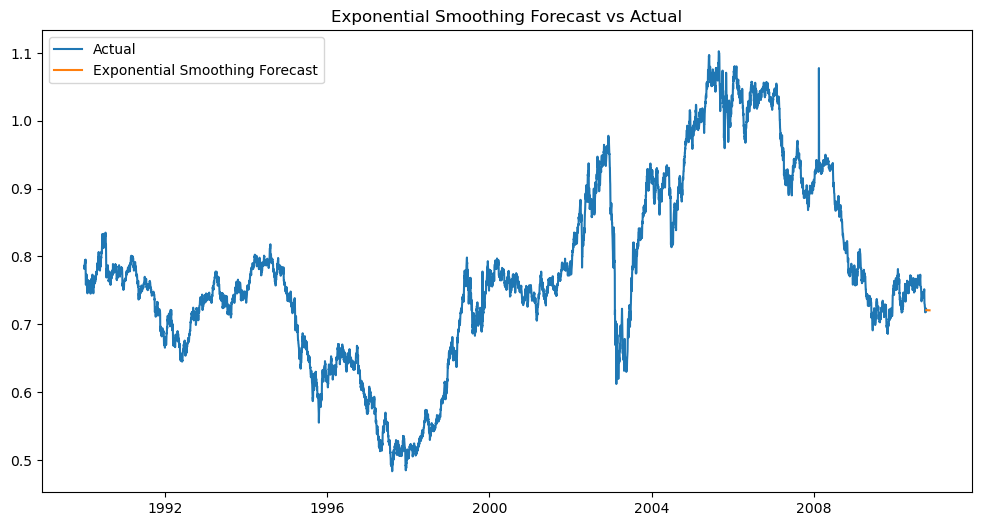

In [65]:
#Model Fitting and Forecasting
#Forecast and compare:
forecast_es = fit_es.forecast(steps=n_forecast)

plt.figure(figsize=(12,6))
plt.plot(df['USD_AUD'], label='Actual')
plt.plot(forecast_index, forecast_es, label='Exponential Smoothing Forecast')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.legend()
plt.show()


In [69]:
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')  # assuming daily data

In [75]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# y_true: actual values from test set
y_true = test['USD_AUD'].values

# y_pred: predicted values from your model
y_pred = forecast.predicted_mean.values  # from model_fit.get_forecast(steps=n_test)

# Calculate errors
mae = mean_absolute_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")



MAE: 0.0135
RMSE: 0.0166
